In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import gzip
import os
import sys
import time
from six.moves import urllib
from six.moves import xrange  
import tensorflow as tf
import numpy as np

import six
from pathlib import Path

import tensorflow as tf
import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import load_model


In [3]:
SOURCE_URL = 'https://storage.googleapis.com/cvdf-datasets/mnist/'
WORK_DIRECTORY = 'data'
IMAGE_SIZE = 28
NUM_CHANNELS = 1
PIXEL_DEPTH = 255
NUM_LABELS = 10
VALIDATION_SIZE = 5000  # Size of the validation set.
SEED = 66478  # Set to None for random seed.
BATCH_SIZE = 64
NUM_EPOCHS = 1
EVAL_BATCH_SIZE = 64
EVAL_FREQUENCY = 100  # Number of steps between evaluations.

In [4]:
def data_type():
  """Return the type of the activations, weights, and placeholder variables."""
#   if FLAGS.use_fp16:
#     return tf.float16
#   else:
  return tf.float32


In [5]:
def maybe_download(filename):
  """Download the data from Yann's website, unless it's already here."""
  if not tf.gfile.Exists(WORK_DIRECTORY):
    tf.gfile.MakeDirs(WORK_DIRECTORY)
  filepath = os.path.join(WORK_DIRECTORY, filename)
  if not tf.gfile.Exists(filepath):
    filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
    with tf.gfile.GFile(filepath) as f:
      size = f.size()
    print('Successfully downloaded', filename, size, 'bytes.')
  return filepath

In [6]:
def extract_data(filename, num_images):
  """Extract the images into a 4D tensor [image index, y, x, channels].
  Values are rescaled from [0, 255] down to [-0.5, 0.5].
  """
  print('Extracting', filename)
  with gzip.open(filename) as bytestream:
    bytestream.read(16)
    buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images * NUM_CHANNELS)
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
    data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
    data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
    return data

In [7]:
def extract_labels(filename, num_images):
  """Extract the labels into a vector of int64 label IDs."""
  print('Extracting', filename)
  with gzip.open(filename) as bytestream:
    bytestream.read(8)
    buf = bytestream.read(1 * num_images)
    labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
  return labels

In [8]:
def fake_data(num_images):
  """Generate a fake dataset that matches the dimensions of MNIST."""
  data = np.ndarray(
      shape=(num_images, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS),
      dtype=np.float32)
  labels = np.zeros(shape=(num_images,), dtype=np.int64)
  for image in xrange(num_images):
    label = image % 2
    data[image, :, :, 0] = label - 0.5
    labels[image] = label
  return data, labels

In [9]:
def error_rate(predictions, labels):
  """Return the error rate based on dense predictions and sparse labels."""
  return 100.0 - (
      100.0 *
      np.sum(np.argmax(predictions, 1) == labels) /
      predictions.shape[0])

In [10]:
train_data_filename = maybe_download('train-images-idx3-ubyte.gz')
train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz')
test_data_filename = maybe_download('t10k-images-idx3-ubyte.gz')
test_labels_filename = maybe_download('t10k-labels-idx1-ubyte.gz')

train_data = extract_data(train_data_filename, 60000)
train_labels = extract_labels(train_labels_filename, 60000)
test_data = extract_data(test_data_filename, 10000)
test_labels = extract_labels(test_labels_filename, 10000)

validation_data = train_data[:VALIDATION_SIZE, ...]
validation_labels = train_labels[:VALIDATION_SIZE]
train_data = train_data[VALIDATION_SIZE:, ...]
train_labels = train_labels[VALIDATION_SIZE:]

num_images = train_labels.shape[0]


Extracting data\train-images-idx3-ubyte.gz
Extracting data\train-labels-idx1-ubyte.gz
Extracting data\t10k-images-idx3-ubyte.gz
Extracting data\t10k-labels-idx1-ubyte.gz


In [11]:
import matplotlib.pyplot as plt
image = np.asarray(train_data[1]).squeeze()
plt.imshow(image)
plt.show()

<Figure size 640x480 with 1 Axes>

In [12]:
train_data.shape

(55000, 28, 28, 1)

In [13]:
# Split data into 3 devices

train_data_device1 = train_data[:18000]
train_data_device2 = train_data[18000:36000]
train_data_device3 = train_data[36000:]

np.save('./device1/mnist-images', train_data_device1)
np.save('./device2/mnist-images', train_data_device2)
np.save('./device3/mnist-images', train_data_device3)

In [14]:
train_labels_device1 = train_labels[:18000]
train_labels_device2 = train_labels[18000:36000]
train_labels_device3 = train_labels[36000:]

# Convert to one-hot encoding
train_labels_ohe_device1 = keras.utils.to_categorical(train_labels_device1, NUM_LABELS)
train_labels_ohe_device2 = keras.utils.to_categorical(train_labels_device2, NUM_LABELS)
train_labels_ohe_device3 = keras.utils.to_categorical(train_labels_device3, NUM_LABELS)

np.save('./device1/mnist-labels', train_labels_ohe_device1)
np.save('./device2/mnist-labels', train_labels_ohe_device2)
np.save('./device3/mnist-labels', train_labels_ohe_device3)

In [15]:
def get_mnist_images_and_labels(device_path):
    images = np.load(device_path + '/mnist-images.npy')
    labels = np.load(device_path + '/mnist-labels.npy')
    return (images, labels)

In [16]:
train_images, train_labels = get_mnist_images_and_labels('./device1')

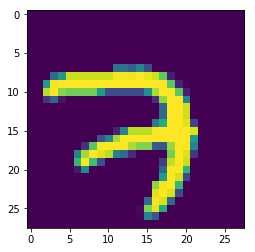

In [17]:
import matplotlib.pyplot as plt
image = np.asarray(train_images[0]).squeeze()
plt.imshow(image)
plt.show()

In [18]:
train_labels[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [19]:
print(tf.version.VERSION)
print(tf.keras.__version__)

1.14.0
2.2.4-tf


# Server

In [22]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 1)

# 
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_LABELS, activation='softmax'))

In [23]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])

In [24]:
#Save model
model.save('./server/model.h5')

# Save weights to a TensorFlow Checkpoint file
model.save_weights('./server/checkpoint')

# Devices

In [25]:
# Returns (n, weight_updates) after training on local data

def train_on_device(device_path, model_path, ckpt_path):
    
    # Store pre-trained model and weights 
    old_model = load_model(model_path)
    old_model.load_weights(ckpt_path)
    
    # Initialize model and checkpoint, which are obtained from server
    device_model = load_model(model_path)
    device_model.load_weights(ckpt_path)
    
#    print(device_model.summary())
    
    # Get training data present on device
    train_images, train_labels = get_mnist_images_and_labels(device_path)
    
    # Train model
    device_model.fit(train_images, train_labels,
          batch_size=BATCH_SIZE,
          epochs=2,
          verbose=1)
    
    # Load model to store weight updates
    update_weights = load_model(model_path)
    
    # Number of batches trained on device
    num_batches = train_images.shape[0] // BATCH_SIZE
    
    # Calculate weight updates
    for i in range(len(device_model.layers)):
        
        # Pre-trained weights
        old_layer_weights = old_model.layers[i].get_weights()
        
        # Post-trained weights        
        new_layer_weights = device_model.layers[i].get_weights()

        # Weight updates calculation
        update_weights.layers[i].set_weights(num_batches * (np.asarray(new_layer_weights) - np.asarray(old_layer_weights)))
    
#        print("old weights: ",  old_layer_weights)
#        print("new weights: ",  new_layer_weights)
#        print("update weights: ",  update_weights.layers[i].get_weights())
    
    
    # Save weight updates
    update_weights_path = device_path + '/weight_updates'
    update_weights.save_weights(update_weights_path)
    
    return (num_batches, update_weights_path)

# Train on devices

In [26]:
model_path = './server/model.h5'
ckpt_path = './server/checkpoint'

In [27]:
# Train on device 1
n_device1, update_weights_device1 = train_on_device('./device1', model_path, ckpt_path)

W0830 15:59:24.906618 18044 deprecation.py:323] From C:\Users\Admin\Anaconda3\envs\dl\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2
18000/18000 [==============================] - 30s 2ms/step - loss: 1.8538 - acc: 0.3845
Epoch 2/2
18000/18000 [==============================] - 5s 272us/step - loss: 0.7543 - acc: 0.7644


In [36]:
# Train on device 2
n_device2, update_weights_device2 = train_on_device('./device2', model_path, ckpt_path)

Epoch 1/2
18000/18000 [==============================] - 5s 269us/step - loss: 0.4777 - acc: 0.8509
Epoch 2/2
18000/18000 [==============================] - 9s 474us/step - loss: 0.4040 - acc: 0.8753


In [37]:
# Train on device 3
n_device3, update_weights_device3 = train_on_device('./device3', model_path, ckpt_path)

Epoch 1/2
19000/19000 [==============================] - 7s 361us/step - loss: 0.4543 - acc: 0.8608
Epoch 2/2
19000/19000 [==============================] - 5s 277us/step - loss: 0.3891 - acc: 0.8805


In [38]:
updates = [(n_device1, update_weights_device1), (n_device2, update_weights_device2), (n_device3, update_weights_device3)]
print(updates)

[(281, './device1/weight_updates'), (281, './device2/weight_updates'), (296, './device3/weight_updates')]


# Federated Averaging

In [39]:
def federated_averaging(updates, model_path, ckpt_path):
    
    total_num_batches = 0
    
    # Load model architecture
    average_weight_updates = load_model(model_path)
    sum_weight_updates = load_model(model_path)
    device_weight_updates = load_model(model_path)
    
    # Calculate sum of weight updates from all devices
    for device_index in range(len(updates)):
        
        n, weight_updates_path = updates[device_index]
        
        total_num_batches += n
        
        if device_index == 0:
             sum_weight_updates.load_weights(weight_updates_path)
                
        else:
            # Load device weight updates checkpoint
            device_weight_updates.load_weights(weight_updates_path)
            
            # Add weight updates from device to prefix sum
            for layer_index in range(len(sum_weight_updates.layers)):

                # Old sum of weight updates
                old_sum_weight_updates_values = sum_weight_updates.layers[layer_index].get_weights()

                # Device weight updates      
                device_weight_updates_values = device_weight_updates.layers[layer_index].get_weights()

                # Weight updates calculation
                sum_weight_updates.layers[layer_index].set_weights(np.asarray(old_sum_weight_updates_values) 
                                                                 + np.asarray(device_weight_updates_values))

#                print("old weights: ",  old_layer_weights)
#                print("new weights: ",  new_layer_weights)
#                print("update weights: ",  update_weights.layers[i].get_weights())

    
    # Calculate average
    for layer_index in range(len(sum_weight_updates.layers)):

        # Value of sum of weight updates
        sum_weight_updates_values = sum_weight_updates.layers[layer_index].get_weights()

        # Calculate average and store
        average_weight_updates.layers[layer_index].set_weights( np.asarray(sum_weight_updates_values)/total_num_batches )

#        print("old weights: ",  old_layer_weights)
#        print("new weights: ",  new_layer_weights)
#        print("update weights: ",  update_weights.layers[i].get_weights())
            
    # Add average of weight updates to checkpoint
    # Load model and checkpoints
    model = load_model(model_path)
    model.load_weights(ckpt_path)
    
    for layer_index in range(len(model.layers)):
        
        # Average of weight updates values
        average_weight_updates_values = average_weight_updates.layers[layer_index].get_weights()
        
        old_model_values = model.layers[layer_index].get_weights()
        
        model.layers[layer_index].set_weights(np.asarray(old_model_values) + np.asarray(average_weight_updates_values))
    
    # Save updated model checkpoints
    model.save_weights(ckpt_path)
        

In [40]:
federated_averaging(updates, model_path, ckpt_path)